In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git pull

!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 15637, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 15637 (delta 123), reused 173 (delta 101), pack-reused 15393
Receiving objects: 100% (15637/15637), 14.65 MiB | 6.95 MiB/s, done.
Resolving deltas: 100% (10647/10647), done.
/content/yolov5
Already up to date.
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.13.0 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
!curl -L "https://app.roboflow.com/ds/YCsKLvAbzh?key=wauxyPlLFl" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   2256      0 --:--:-- --:--:-- --:--:--  2258
100 67.7M  100 67.7M    0     0  44.6M      0  0:00:01  0:00:01 --:--:-- 73.9M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: train/
   creating: train/images/
 extracting: train/images/train_BLA_0001_JPG.rf.6dfdc831a8d4eeccb161f8ec4135cb5c.jpg  
 extracting: train/images/train_BLA_0003_JPG.rf.c69e21b8092edf615d65223dce972852.jpg  
 extracting: train/images/train_BLA_0004_JPG.rf.50b023488b13e33cb0ad8a592ae8631d.jpg  
 extracting: train/images/train_BLA_0005_JPG.rf.eba3b36853391b05129bca52bf72e864.jpg  
 extracting: train/images/train_BLA_0007_JPG.rf.0593c71b90ae833c61c91eecf2a5cdca.jpg  
 extracting: train/images/train_BLA_0008_JPG.rf.a3adf62e4d2bc6979376b184f4231f95.jpg  
 extracting: tra

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['human']

In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat ./data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['human']

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate ./data.yaml

# parameters
train : ./train
val : ./valid
names : ['Person']
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat ./models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [ ]:
!pip install wandb -q

In [ ]:
cd yolov5

[Errno 2] No such file or directory: 'yolov5'
/kaggle/working/yolov5


In [ ]:
ls

Dockerfile           data/       models/            train.py        weights/
LICENSE              data.yaml   requirements.txt*  tutorial.ipynb
README.md*           detect.py   test.py            utils/
README.roboflow.txt  hubconf.py  train/             valid/


In [ ]:
!git pull

Updating 886f1c0..8ecc727
Fast-forward
 .dockerignore                                      |   14 +-
 .github/ISSUE_TEMPLATE/bug-report.md               |   55 -
 .github/ISSUE_TEMPLATE/bug-report.yml              |   85 ++
 .github/ISSUE_TEMPLATE/config.yml                  |   11 +
 .github/ISSUE_TEMPLATE/feature-request.md          |   27 -
 .github/ISSUE_TEMPLATE/feature-request.yml         |   50 +
 .github/ISSUE_TEMPLATE/question.md                 |   13 -
 .github/ISSUE_TEMPLATE/question.yml                |   33 +
 .github/PULL_REQUEST_TEMPLATE.md                   |   13 +
 .github/dependabot.yml                             |   31 +-
 .github/workflows/ci-testing.yml                   |  201 ++-
 .github/workflows/codeql-analysis.yml              |   66 +-
 .github/workflows/docker.yml                       |   57 +
 .github/workflows/greetings.yml                    |   73 +-
 .github/workflows/links.yml                        |   38 +
 .github/workflows/rebase.yml          

In [ ]:
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda:0")
else:
    print("GPU not available, using CPU instead")
    device = torch.device("cpu")


GPU is available


In [ ]:
!export WANDB_API_KEY=742aac2df6aee3508d1fdb5ad95cb60e7ea2dbdd && python train.py --img 416 --batch 16 --epochs 100 --data './data.yaml' --cfg ./models/yolov5s.yaml --weights '' --name ./yolov5s_results --cache

wandb: WARNING ‚ö†Ô∏è wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: maxim652002 (itmo_). Use `wandb login --relogin` to force relogin
train: weights=, cfg=./models/yolov5s.yaml, data=./data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=./yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ‚úÖ
requirements: /kaggle/working/requirements.txt not found, ch

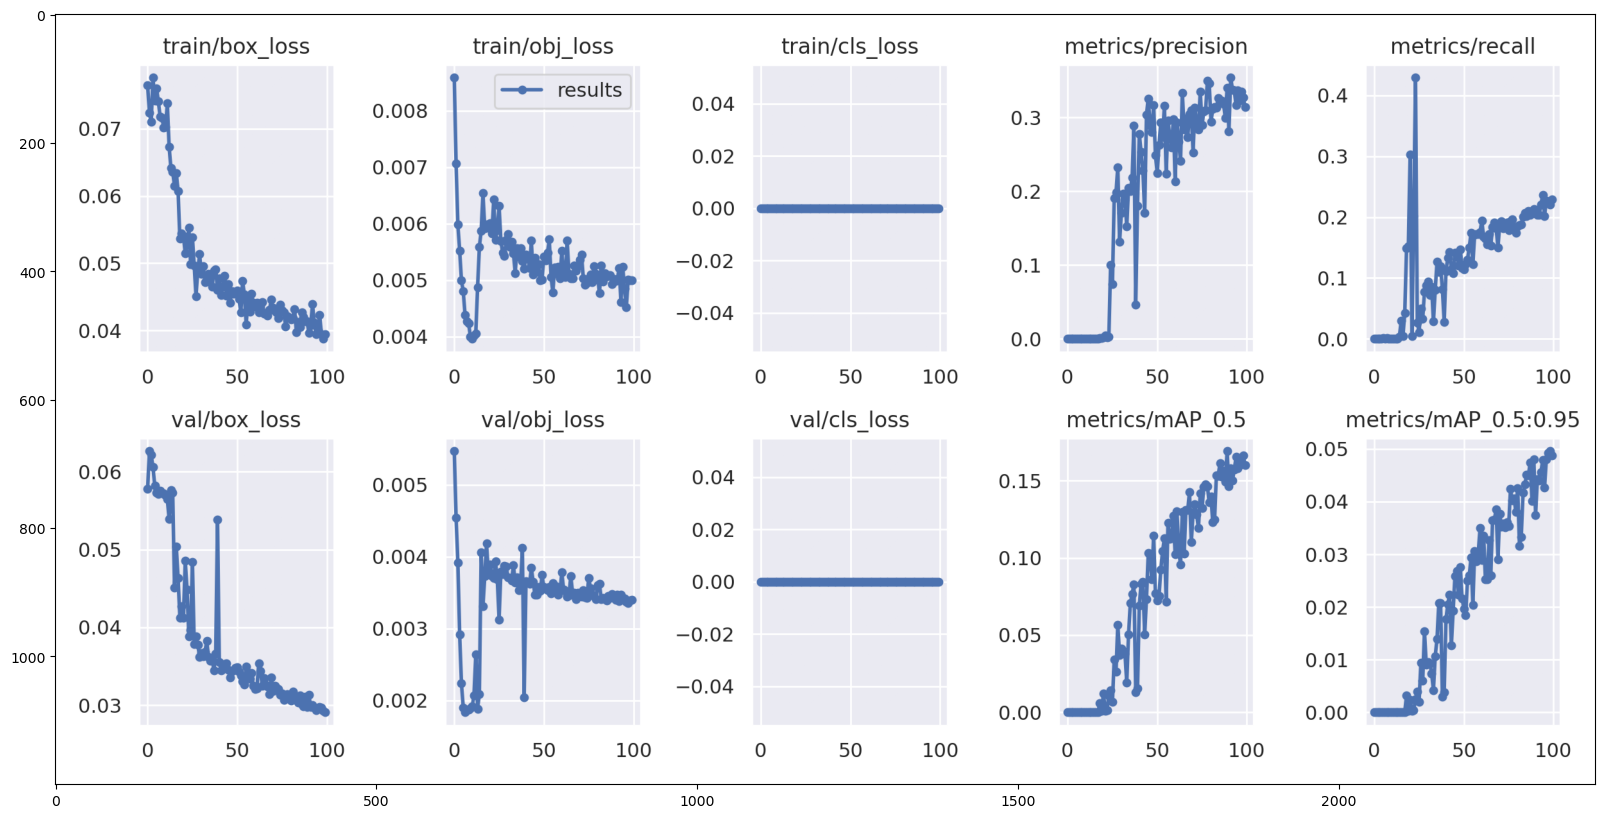

In [ ]:
img = mpimg.imread('./runs/train/yolov5s_results2/results.png')

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.show()

In [ ]:
!python detect.py --weights ./runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source ./valid/images

detect: weights=['./runs/train/yolov5s_results2/weights/best.pt'], source=./valid/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /kaggle/working/requirements.txt not found, check failed.
YOLOv5 üöÄ v7.0-155-g8ecc727 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/377 /kaggle/working/yolov5/valid/images/train_BLA_0002_JPG.rf.0853fda95c799c8d505bdcf8bb5937d4.jpg: 416x416 1 Person, 11.0ms
image 2/377 /kaggle/working/yolov5/valid/images/train_BLA_0006_JPG.rf.586dd34289f6bc89c3fd33b16c30190e.jpg: 416x416 2 Persons, 12.4ms

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

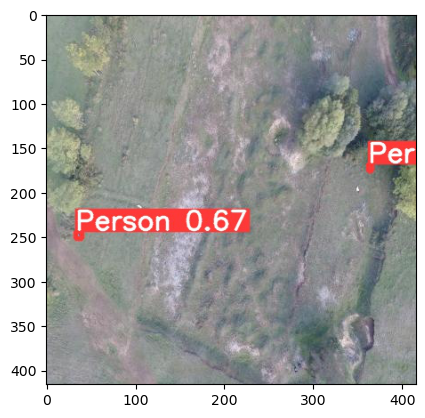

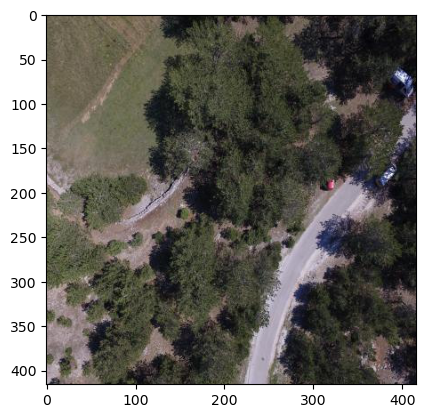

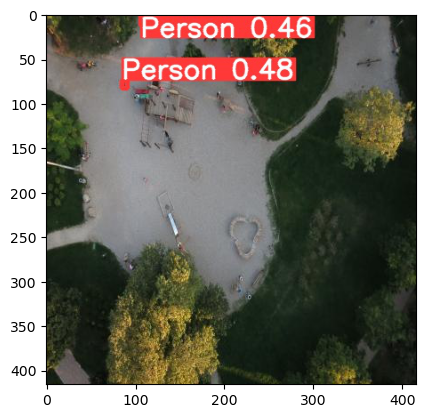

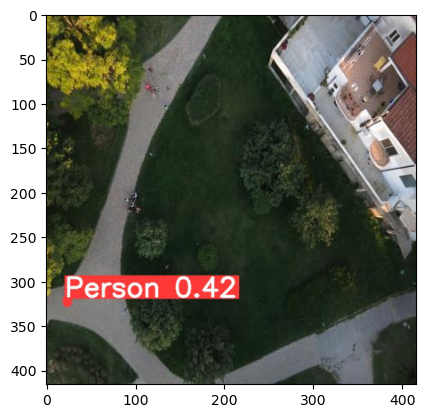

In [ ]:
for det_img in [
    'train_BLA_0006_JPG.rf.586dd34289f6bc89c3fd33b16c30190e.jpg',
    'train_BRA_1003_JPG.rf.a3f32a60314fdb79d054f284d712f1c8.jpg',
    'train_ZRI_2012_JPG.rf.c9d7bfac5fbc26c34c2e567ee09ed736.jpg',
    'train_ZRI_2018_JPG.rf.20a15d8fc0c97f8f4add326d3890030c.jpg']:
    # –ó–∞–≥—Ä—É–∑–∫–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
    img = mpimg.imread('/kaggle/working/yolov5/runs/detect/exp6/'+det_img)

    # –û—Ç–æ–±—Ä–∞–∂–µ–Ω–∏–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
    plt.imshow(img)
    plt.show()

In [ ]:
!python val.py --weights ./runs/train/yolov5s_results2/weights/best.pt --data ./data.yaml --img 416 --half

val: data=./data.yaml, weights=['./runs/train/yolov5s_results2/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
requirements: /kaggle/working/requirements.txt not found, check failed.
YOLOv5 üöÄ v7.0-155-g8ecc727 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /kaggle/working/yolov5/valid/labels.cache... 377 images, 149 backg
                 Class     Images  Instances          P          R      mAP50   
                   all        377        638       0.33      0.221      0.166     0.0496
Speed: 0.2ms pre-process, 2.3ms inference, 1.9ms NMS per image at shape (32, 3, 416, 416)
Results saved to runs/val/exp


In [ ]:
!ls /runs/val/exp

F1_curve.png  confusion_matrix.png   val_batch1_pred.jpg
PR_curve.png  val_batch0_labels.jpg  val_batch2_labels.jpg
P_curve.png   val_batch0_pred.jpg    val_batch2_pred.jpg
R_curve.png   val_batch1_labels.jpg


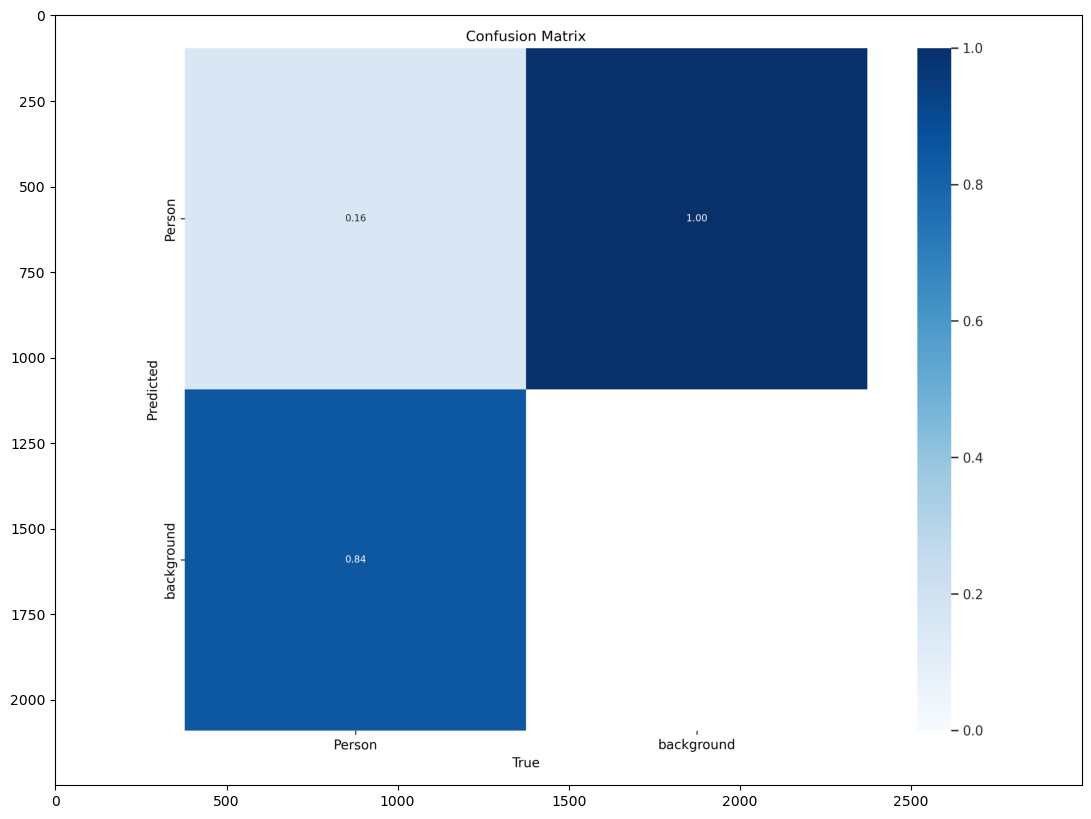

In [ ]:
img = mpimg.imread('./runs/val/exp/confusion_matrix.png')

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.show()

#### FPS
FPS –æ–∑–Ω–∞—á–∞–µ—Ç ¬´–ö–∞–¥—Ä–æ–≤ –≤ —Å–µ–∫—É–Ω–¥—É¬ª. –≠—Ç–æ –º–µ—Ç—Ä–∏–∫–∞, –æ–±—ã—á–Ω–æ –∏—Å–ø–æ–ª—å–∑—É–µ–º–∞—è –¥–ª—è –æ—Ü–µ–Ω–∫–∏ –ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ –ø—Ä–∏–ª–æ–∂–µ–Ω–∏–π –∫–æ–º–ø—å—é—Ç–µ—Ä–Ω–æ–≥–æ –∑—Ä–µ–Ω–∏—è –≤ —Ä–µ–∞–ª—å–Ω–æ–º –≤—Ä–µ–º–µ–Ω–∏, —Ç–∞–∫–∏—Ö –∫–∞–∫ –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∏–µ –æ–±—ä–µ–∫—Ç–æ–≤, –æ—Ç—Å–ª–µ–∂–∏–≤–∞–Ω–∏–µ –∏ –æ–±—Ä–∞–±–æ—Ç–∫–∞ –≤–∏–¥–µ–æ. –í –∫–æ–Ω—Ç–µ–∫—Å—Ç–µ –º–æ–¥–µ–ª–µ–π –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∏—è –æ–±—ä–µ–∫—Ç–æ–≤ –∏ –≥–ª—É–±–æ–∫–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è, —Ç–∞–∫–∏—Ö –∫–∞–∫ YOLO, FPS –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –¥–ª—è –∏–∑–º–µ—Ä–µ–Ω–∏—è —Ç–æ–≥–æ, –Ω–∞—Å–∫–æ–ª—å–∫–æ –±—ã—Å—Ç—Ä–æ –º–æ–¥–µ–ª—å –º–æ–∂–µ—Ç –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞—Ç—å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –Ω–∞ —ç—Ç–∞–ø–µ –≤—ã–≤–æ–¥–∞ –∏–ª–∏ –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è, –∞ –Ω–µ –Ω–∞ —ç—Ç–∞–ø–µ –æ–±—É—á–µ–Ω–∏—è.

–ë–æ–ª–µ–µ –≤—ã—Å–æ–∫–∏–π FPS —É–∫–∞–∑—ã–≤–∞–µ—Ç –Ω–∞ —Ç–æ, —á—Ç–æ –º–æ–¥–µ–ª—å –º–æ–∂–µ—Ç –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞—Ç—å –±–æ–ª—å—à–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∑–∞ –∑–∞–¥–∞–Ω–Ω—ã–π –ø—Ä–æ–º–µ–∂—É—Ç–æ–∫ –≤—Ä–µ–º–µ–Ω–∏, —á—Ç–æ –¥–µ–ª–∞–µ—Ç –µ–µ –±–æ–ª–µ–µ –ø–æ–¥—Ö–æ–¥—è—â–µ–π –¥–ª—è –ø—Ä–∏–ª–æ–∂–µ–Ω–∏–π —Ä–µ–∞–ª—å–Ω–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏, –≥–¥–µ —Ç—Ä–µ–±—É–µ—Ç—Å—è –±—ã—Å—Ç—Ä–æ–µ –∏ —Ç–æ—á–Ω–æ–µ –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∏–µ. –ë–æ–ª–µ–µ –Ω–∏–∑–∫–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è FPS –º–æ–≥—É—Ç –±—ã—Ç—å –Ω–µ –∏–¥–µ–∞–ª—å–Ω—ã–º–∏ –¥–ª—è —Å—Ü–µ–Ω–∞—Ä–∏–µ–≤ —Ä–µ–∞–ª—å–Ω–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏, –Ω–æ –≤—Å–µ –∂–µ –º–æ–≥—É—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è –≤ –º–µ–Ω–µ–µ —á—É–≤—Å—Ç–≤–∏—Ç–µ–ª—å–Ω—ã—Ö –∫–æ –≤—Ä–µ–º–µ–Ω–∏ –ø—Ä–∏–ª–æ–∂–µ–Ω–∏—è—Ö.

–ü–æ—Å—á–∏—Ç–∞–µ–º –µ–≥–æ –æ—Å–Ω–æ–≤—ã–≤–∞—è—Å—å –Ω–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞—Ö –¥–µ—Ç–µ–∫—Ü–∏–∏:

    - Pre-process time: 0.3ms
    - Inference time: 11.2ms
    - NMS (Non-Maximum Suppression) time: 0.3ms
    
–ß—Ç–æ–±—ã —Ä–∞—Å—Å—á–∏—Ç–∞—Ç—å FPS, –Ω—É–∂–Ω–æ —Å–ª–æ–∂–∏—Ç—å —ç—Ç–∏ –≤—Ä–µ–º–µ–Ω–∞ –≤–º–µ—Å—Ç–µ, —á—Ç–æ–±—ã –ø–æ–ª—É—á–∏—Ç—å –æ–±—â–µ–µ –≤—Ä–µ–º—è –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ, –∞ –∑–∞—Ç–µ–º –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞—Ç—å –µ–≥–æ –≤ –∫–∞–¥—Ä—ã –≤ —Å–µ–∫—É–Ω–¥—É.

–û–±—â–µ–µ –≤—Ä–µ–º—è –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ (–≤ —Å–µ–∫—É–Ω–¥–∞—Ö) = (0,3 + 11,2 + 0,3) / 1000 = 0,0118 —Å–µ–∫—É–Ω–¥

–¢–µ–ø–µ—Ä—å –ø–æ—Å—á–∏—Ç–∞–µ–º FPS:

FPS = 1 / –û–±—â–µ–µ –≤—Ä–µ–º—è –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ = 1 / 0,0118 = 84,75

–ò—Ç–∞–∫, FPS –¥–ª—è –≤–∞—à–µ–π –º–æ–¥–µ–ª–∏ —Å–æ—Å—Ç–∞–≤–ª—è–µ—Ç 84,75.

## –ò—Ç–æ–≥
–ú—ã –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–ª–∏ –º–æ–¥–µ–ª—å Yolo V5 small
–≠—Ç–æ –Ω–∞—Å—Ç—Ä–∞–∏–≤–∞–µ–º—ã–π —Ñ–∞–π–ª –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–∏ –º–æ–¥–µ–ª–∏ YOLOv5. –ú–æ–¥–µ–ª—å –∏–º–µ–µ—Ç –∫–æ–Ω—Å—Ç—Ä—É–∫—Ü–∏—é, —Å–æ—Å—Ç–æ—è—â—É—é –∏–∑ –ø–æ–∑–≤–æ–Ω–æ—á–Ω–∏–∫–∞ –∏ –≥–æ–ª–æ–≤—ã. –ú–∞–≥–∏—Å—Ç—Ä–∞–ª—å –æ—Ç–≤–µ—á–∞–µ—Ç –∑–∞ –∏–∑–≤–ª–µ—á–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤, –∞ –≥–æ–ª–æ–≤–∫–∞ –æ—Ç–≤–µ—á–∞–µ—Ç –∑–∞ –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∏–µ –æ–±—ä–µ–∫—Ç–æ–≤ —Å –ø–æ–º–æ—â—å—é –±–ª–æ–∫–æ–≤ –ø—Ä–∏–≤—è–∑–∫–∏. –í–æ—Ç —Ä–∞–∑–±–∏–≤–∫–∞ —Å—Ç—Ä—É–∫—Ç—É—Ä—ã:

 train –∏ val —É–∫–∞–∑—ã–≤–∞—é—Ç –ø—É—Ç–∏ –Ω–∞–±–æ—Ä–∞ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –∏ –ø—Ä–æ–≤–µ—Ä–∫–∏ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω–æ.
 –∏–º–µ–Ω–∞ —Å–æ–¥–µ—Ä–∂–∞—Ç –∏–º–µ–Ω–∞ –∫–ª–∞—Å—Å–æ–≤ –≤ –≤–∞—à–µ–º –Ω–∞–±–æ—Ä–µ –¥–∞–Ω–Ω—ã—Ö (–≤ –¥–∞–Ω–Ω–æ–º —Å–ª—É—á–∞–µ ¬´–ß–µ–ª–æ–≤–µ–∫¬ª).
 nc ‚Äî –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–ª–∞—Å—Å–æ–≤.
 depth_multiple –∏ width_multiple ‚Äî —ç—Ç–æ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã, —É–ø—Ä–∞–≤–ª—è—é—â–∏–µ –≥–ª—É–±–∏–Ω–æ–π –∏ —à–∏—Ä–∏–Ω–æ–π –º–æ–¥–µ–ª–∏.
 –ø—Ä–∏–≤—è–∑–∫–∏ ‚Äî —ç—Ç–æ –ø—Ä–µ–¥–æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã–µ —Ä–∞–∑–º–µ—Ä—ã –±–ª–æ–∫–∞ –ø—Ä–∏–≤—è–∑–∫–∏ –¥–ª—è —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –º–∞—Å—à—Ç–∞–±–æ–≤ –∫–∞—Ä—Ç—ã –æ–±—ä–µ–∫—Ç–æ–≤ (P3/8, P4/16, P5/32).

–ö–æ—Å—Ç—è–∫ —Å–æ—Å—Ç–æ–∏—Ç –∏–∑:

Focus layer: –æ–±—ä–µ–¥–∏–Ω—è–µ—Ç –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–µ–Ω–Ω—É—é –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –æ—Ç —Å–æ—Å–µ–¥–Ω–∏—Ö –ø–∏–∫—Å–µ–ª–µ–π –≤–æ –≤—Ö–æ–¥–Ω–æ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–∏.
Conv layers: –≤—ã–ø–æ–ª–Ω–∏—Ç–µ —Å–≤–µ—Ä—Ç–∫–∏ —Å —à–∞–≥–æ–º 2, —á—Ç–æ–±—ã —É–º–µ–Ω—å—à–∏—Ç—å –≤—ã–±–æ—Ä–∫—É –∫–∞—Ä—Ç –æ–±—ä–µ–∫—Ç–æ–≤.
BottleneckCSP layers: –º–µ–∂—ç—Ç–∞–ø–Ω—ã–µ –∏–µ—Ä–∞—Ä—Ö–∏—á–µ—Å–∫–∏–µ —Å–µ—Ç–∏ –¥–ª—è –ª—É—á—à–µ–≥–æ –≥—Ä–∞–¥–∏–µ–Ω—Ç–Ω–æ–≥–æ –ø–æ—Ç–æ–∫–∞ –∏ –ø–æ–≤—Ç–æ—Ä–Ω–æ–≥–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è —Ñ—É–Ω–∫—Ü–∏–π.
SPP (Spatial Pyramid Pooling) layer: –æ–±—ä–µ–¥–∏–Ω—è–µ—Ç –æ–±—ä–µ–∫—Ç—ã –≤ –Ω–µ—Å–∫–æ–ª—å–∫–∏—Ö –º–∞—Å—à—Ç–∞–±–∞—Ö –¥–ª—è –ª—É—á—à–µ–≥–æ –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∏—è –æ–±—ä–µ–∫—Ç–æ–≤ –≤ —Ä–∞–∑–Ω—ã—Ö –º–∞—Å—à—Ç–∞–±–∞—Ö.

head —Å–æ—Å—Ç–æ–∏—Ç –∏–∑:

 –°–ª–æ–∏ Conv: —É–º–µ–Ω—å—à–∏—Ç–µ —Ä–∞–∑–º–µ—Ä –∫–∞–Ω–∞–ª–∞ –∫–∞—Ä—Ç –æ–±—ä–µ–∫—Ç–æ–≤.
 –ü–æ–≤—ã—à–µ–Ω–∏–µ –¥–∏—Å–∫—Ä–µ—Ç–∏–∑–∞—Ü–∏–∏ —Å–ª–æ–µ–≤: –ø–æ–≤—ã—à–∞–π—Ç–µ –¥–∏—Å–∫—Ä–µ—Ç–∏–∑–∞—Ü–∏—é –∫–∞—Ä—Ç –æ–±—ä–µ–∫—Ç–æ–≤ –¥–ª—è –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è —Å –æ–±—ä–µ–∫—Ç–∞–º–∏ –±–æ–ª–µ–µ –Ω–∏–∑–∫–æ–≥–æ —É—Ä–æ–≤–Ω—è.
 –°–ª–æ–∏ Concat: –æ–±—ä–µ–¥–∏–Ω—è–π—Ç–µ –∫–∞—Ä—Ç—ã –æ–±—ä–µ–∫—Ç–æ–≤ –∏–∑ –æ—Å–Ω–æ–≤—ã –∏ –≥–æ–ª–æ–≤—ã.
 –°–ª–æ–∏ —É–∑–∫–∏—Ö –º–µ—Å—Ç CSP: –£—Ç–æ—á–Ω–∏—Ç–µ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–Ω—ã–µ –∫–∞—Ä—Ç—ã –æ–±—ä–µ–∫—Ç–æ–≤.
 –°–ª–æ–π –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∏—è: –≤—ã–ø–æ–ª–Ω–∏—Ç–µ –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∏–µ –æ–±—ä–µ–∫—Ç–æ–≤ —Å –ø–æ–º–æ—â—å—é –ø–æ–ª–µ–π –ø—Ä–∏–≤—è–∑–∫–∏ –∏ –≤—ã–≤–µ–¥–∏—Ç–µ –æ–∫–æ–Ω—á–∞—Ç–µ–ª—å–Ω—ã–µ –ø—Ä–æ–≥–Ω–æ–∑—ã.

–ú–æ–¥–µ–ª—å –∏—Å–ø–æ–ª—å–∑—É–µ—Ç —Ç—Ä–∏ —Ä–∞–∑–Ω—ã—Ö –º–∞—Å—à—Ç–∞–±–∞ –∫–∞—Ä—Ç—ã –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (P3/8, P4/16, P5/32) –¥–ª—è –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∏—è –æ–±—ä–µ–∫—Ç–æ–≤, —á—Ç–æ –ø–æ–º–æ–≥–∞–µ—Ç –æ–±–Ω–∞—Ä—É–∂–∏–≤–∞—Ç—å –æ–±—ä–µ–∫—Ç—ã —Ä–∞–∑–Ω—ã—Ö —Ä–∞–∑–º–µ—Ä–æ–≤ –Ω–∞ –≤—Ö–æ–¥–Ω—ã—Ö –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è—Ö.

## –º–µ—Ç—Ä–∏–∫–∏
- P    0.33          
- R    0.221    
- mAP50 0.166 
- mAP50-95: 0.049
- FPS 84,75

In [ ]:
import shutil

shutil.move('source_path/filename.extension', '/kaggle/working/filename.extension')


In [ ]:
!tar -czf output.tar.gz /kaggle/working/*
